<a href="https://colab.research.google.com/github/xiaoyi-yuxiao/revert-code-to-python/blob/master/BinomimalOptionModel_2020_06_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

define a balanced binary tree

In [ ]:
class Binode(object):
  
  def __init__(self,element=None,down=None,up=None):
    self.element = element
    self.up = up
    self.down = down

  def dict_form(self):
    dict_data = {'up':self.up,'down':self.down,'element':self.element}
    return dict_data

class Tree(object):

  def __init__(self,root=None):
    self.root = root

#add node from bottom up
  def add_node(self,element):
    new_node = Binode(element)
    if self.root == None:
      self.root = new_node
    else:
      node_queue = list()
      node_queue.append(self.root)
      while len(node_queue):
        cur_node = node_queue.pop(0)
        if cur_node.down == None:
          cur_node.down = new_node
        elif cur_node.up == None:
          cur_node.up = new_node
        else:
          node_queue.append(curnode.down)
          node_queue.append(curnode.up)

Find position for each node(prepare for doubling node)

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    if not nx.is_tree(G):
        raise TypeError('Need to define a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

Final stage  Run this one

In [2]:
###construct labels for the graph
def construct_labels(initial_price,N,u,d):
  
#define a dict contains first layer [layer0:initial price]
  list_node = {'layer0':[initial_price]}
#set a for loop to from 1 to N-1
  for layer in range(1,N+1):
#construct a layer in each loop
    cur_layer = list()
    prev_layer = list_node['layer'+str(layer-1)]
    for ele in range(len(prev_layer)):
      cur_layer.append(round(d*prev_layer[ele],10))
      
    cur_layer.append(round(u*prev_layer[ele],10))
    #cur_layer = np.unique(cur_layer)
    dict_data = {'layer'+str(layer):cur_layer}
    list_node.update(dict_data)
  
  return list_node
#store cur-1 layer 
#for each ele in cur-1 layer, update value in cur layer

In [3]:
def construct_Ecallput_node(list_node,K,N,u,d,r,call_put):
  p_tel = (1+r-d)/(u-d)
  q_tel = 1-p_tel
  #store the last layer of the list node to a new dict
  last_layer = list_node['layer'+str(N)]
  #use max(x-k,0) to recalculate the value of that layer
  if call_put=='call':
    last_layer = np.subtract(last_layer,K)
  else:
    last_layer = np.subtract(K,last_layer)
  last_layer = [max(ele,0) for ele in last_layer]
  #construct a new dict to store next layer's value
  call_node = {'layer'+str(N):last_layer}
  #construct for loop from layer end-1 to 0
  for layer in reversed(range(N)):
    cur_layer = list()
    propagate_layer = call_node['layer'+str(layer+1)]
    #instide the for loop.construct another for loop from the first element to end-1
    for ele in range(len(propagate_layer)-1):
      #calculate the value for the next layer and add to it
      val = (propagate_layer[ele]*q_tel+propagate_layer[ele+1]*p_tel)/(1+r)
      cur_layer.append(round(val,10))
    dict_data = {'layer'+str(layer):cur_layer}
    call_node.update(dict_data)

  return call_node
  
  #need to reconstruct plot, can't use netwrokx

In [4]:
def construct_Acallput_node(list_node,K,N,u,d,r,call_put):
  p_tel = (1+r-d)/(u-d)
  q_tel = 1-p_tel
  #store the last layer of the list node to a new dict
  last_layer = list_node['layer'+str(N)]
  #use max(x-k,0) to recalculate the value of that layer
  if call_put=='call':
    last_layer = np.subtract(last_layer,K)
  else:
    last_layer = np.subtract(K,last_layer)
  last_layer = [max(ele,0) for ele in last_layer]
  #construct a new dict to store next layer's value
  call_node = {'layer'+str(N):last_layer}
  #construct for loop from layer end-1 to 0
  for layer in reversed(range(N)):
    cur_layer = list()
    propagate_layer = call_node['layer'+str(layer+1)]
    #instide the for loop.construct another for loop from the first element to end-1
    for ele in range(len(propagate_layer)-1):
      #calculate the value for the next layer and add to it
      val = (propagate_layer[ele]*q_tel+propagate_layer[ele+1]*p_tel)/(1+r)

      ## the main difference between european and american option is the following##
      
      if call_put=='call':
        pre_exercise = max(list_node['layer'+str(layer)][ele]-K,0)# 
      else:
        pre_exercise = max(K-list_node['layer'+str(layer)][ele],0)

      val = max(val,pre_exercise)#compare new val with pre_exercised one
      cur_layer.append(round(val,10))
    dict_data = {'layer'+str(layer):cur_layer}
    call_node.update(dict_data)
    
  return call_node
  
  #need to reconstruct plot, can't use netwrokx

In [5]:
#input price variation and Put option for American
def color_map(list_node_o,list_node_a,N,K):
  #construct a dictionary to store labels
  color_map = []
#define a for loop from 0 to N
  for layer in range(N+1):
#define a for loop from 0 to len(list_node['layer])
    for ele in range(len(list_node_o['layer'+str(layer)])):
      pre_exercise = max(K-list_node_o['layer'+str(layer)][ele],0)
      val = list_node_a['layer'+str(layer)][ele]
      if val<pre_exercise:
        color_map.append('red')
      else:
        color_map.append('skyblue')
#dict.append(counter:list_node['layer][])
#counter++
  return color_map

In [6]:
def construct_nodelabel(list_node,N):
#construct a dictionary to store labels
  nodelabel = {}
#define a for loop from 0 to N
  for layer in range(N+1):
#define a for loop from 0 to len(list_node['layer])
    for ele in range(len(list_node['layer'+str(layer)])):
      dict_data = {str(layer)+str(ele):round(list_node['layer'+str(layer)][ele],2)}
      nodelabel.update(dict_data)
#dict.append(counter:list_node['layer][])
#counter++
  return nodelabel

In [7]:
def construct_node(node_list,N):
#set a for loop from 0 to n-1
  G = nx.Graph()
  for layer in range(N):
#store layer current and layer next
    cur_layer = node_list['layer'+str(layer)]
#for each ele in current layer, add_edge to ele on next layer and next ele on next layer
    for ele in range(len(cur_layer)):
      G.add_edge(str(layer)+str(ele),str(layer+1)+str(ele))
      G.add_edge(str(layer)+str(ele),str(layer+1)+str(ele+1))
  return G

In [8]:
def construct_nodepos(node_list):
  position = {}
  for layer in range(len(node_list)):
    cur_layer = node_list['layer'+str(layer)]

    for element in range(len(cur_layer)):
      ele_tuple = (layer, -1*layer+2*element) #ele*2 for the gap between up and down is 2
      dict_data = {str(layer)+str(element):ele_tuple}
      position.update(dict_data)

  return position

In [16]:
def usr_input():
  
  initial_price = input('Stock Price - S (Defualt : 100) --> ') or 100
  K = input('Strike price - X (Default 100) --> ') or 100
  u = input('Increasae Factor - u (Default 1.175) --> ') or 1.175
  d = input('Decrease Factor - d (Default 0.85) --> ') or .85
  N = input('Periods (less than 9) (Default 4)  --> ') or 4
  r = input('Interest Rate - r (Default 0.07) --> ') or .07
  A_E = input('American or European (Default European) --> ') or 'European'
  return int(N),float(initial_price),float(u),float(d),float(r),float(K), A_E
N,initial_price,u,d,r,K,A_E = usr_input()
number_of_calculation = 0
for i in range(N+2):
  number_of_calculation = number_of_calculation+i

Stock Price - S (Defualt : 100) --> 
Strike price - X (Default 100) --> 
Increasae Factor - u (Default 1.175) --> 
Decrease Factor - d (Default 0.85) --> 
Periods (less than 9) (Default 4)  --> 
Interest Rate - r (Default 0.07) --> 
American or European (Default European) --> American


The price fluctuation tree plot

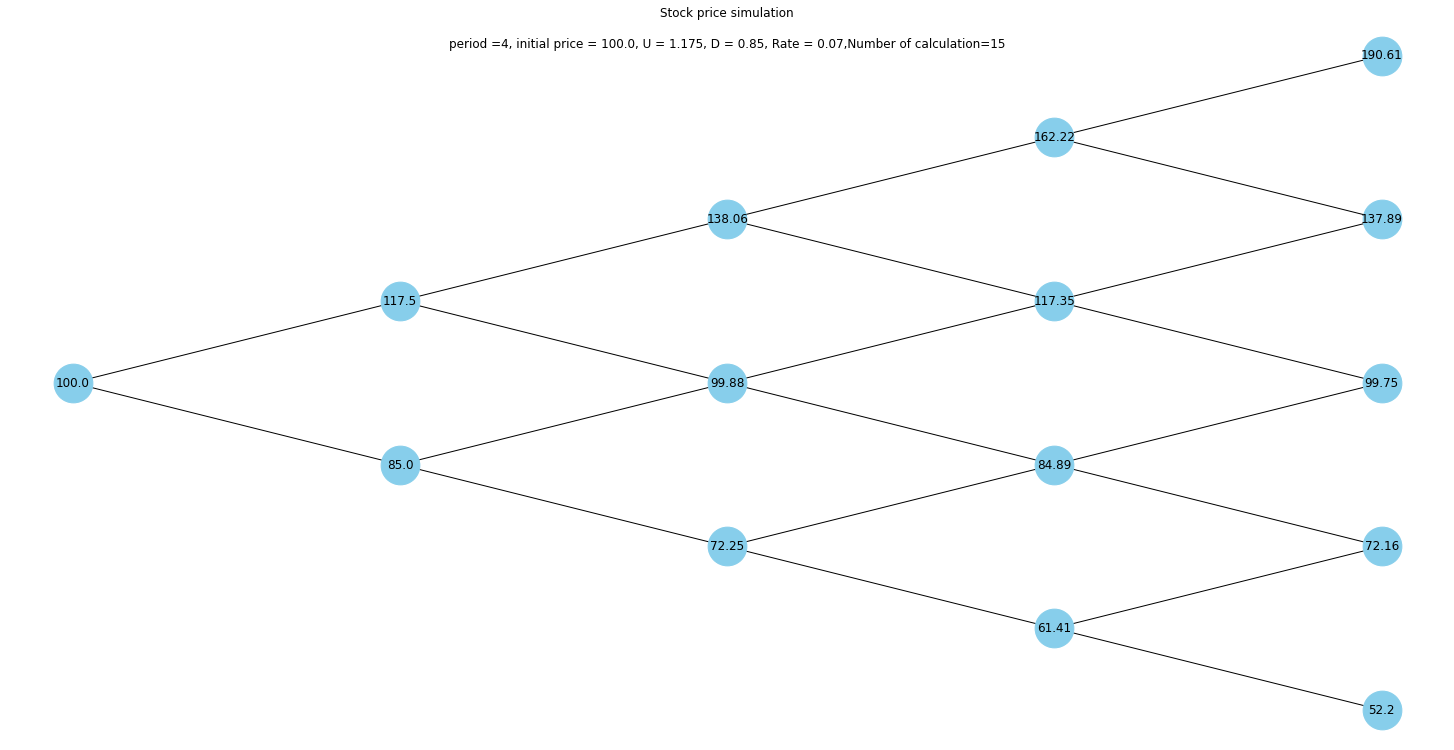

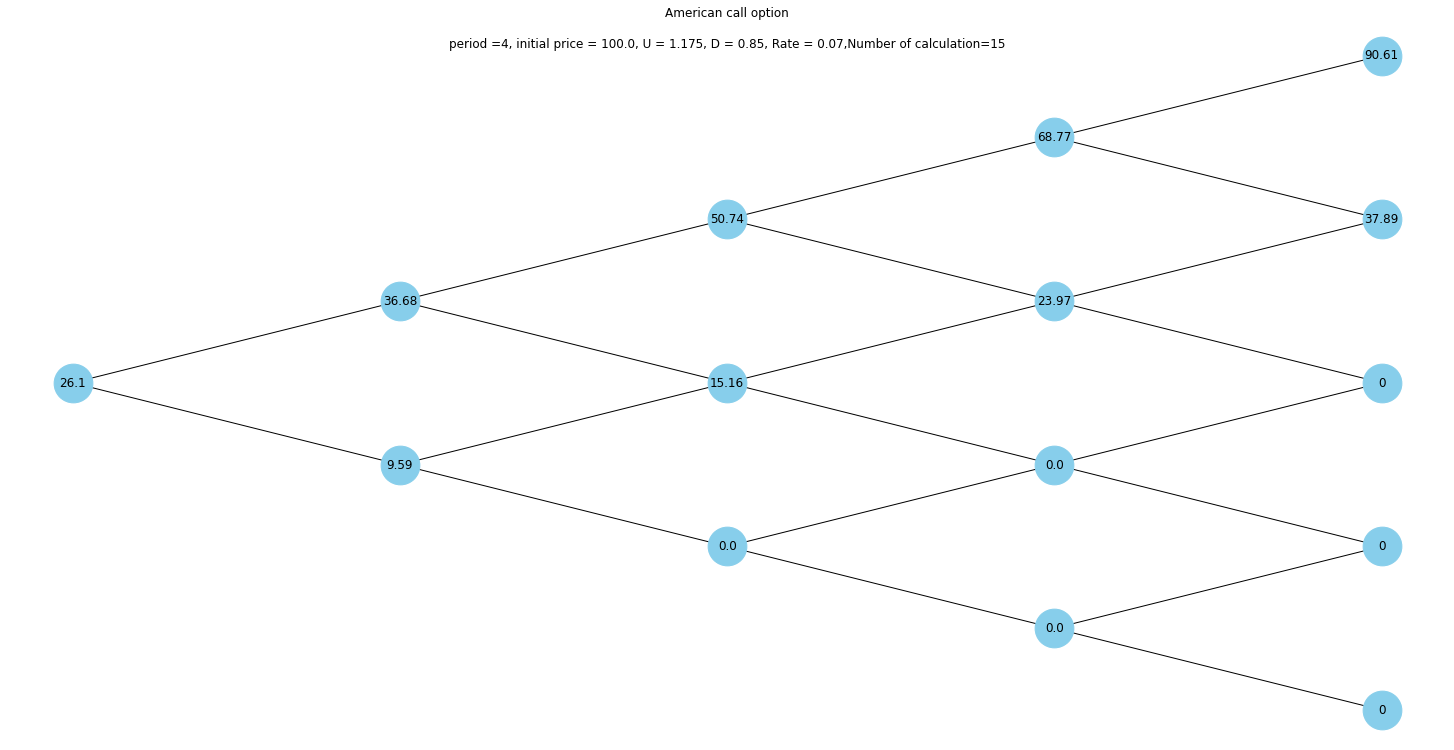

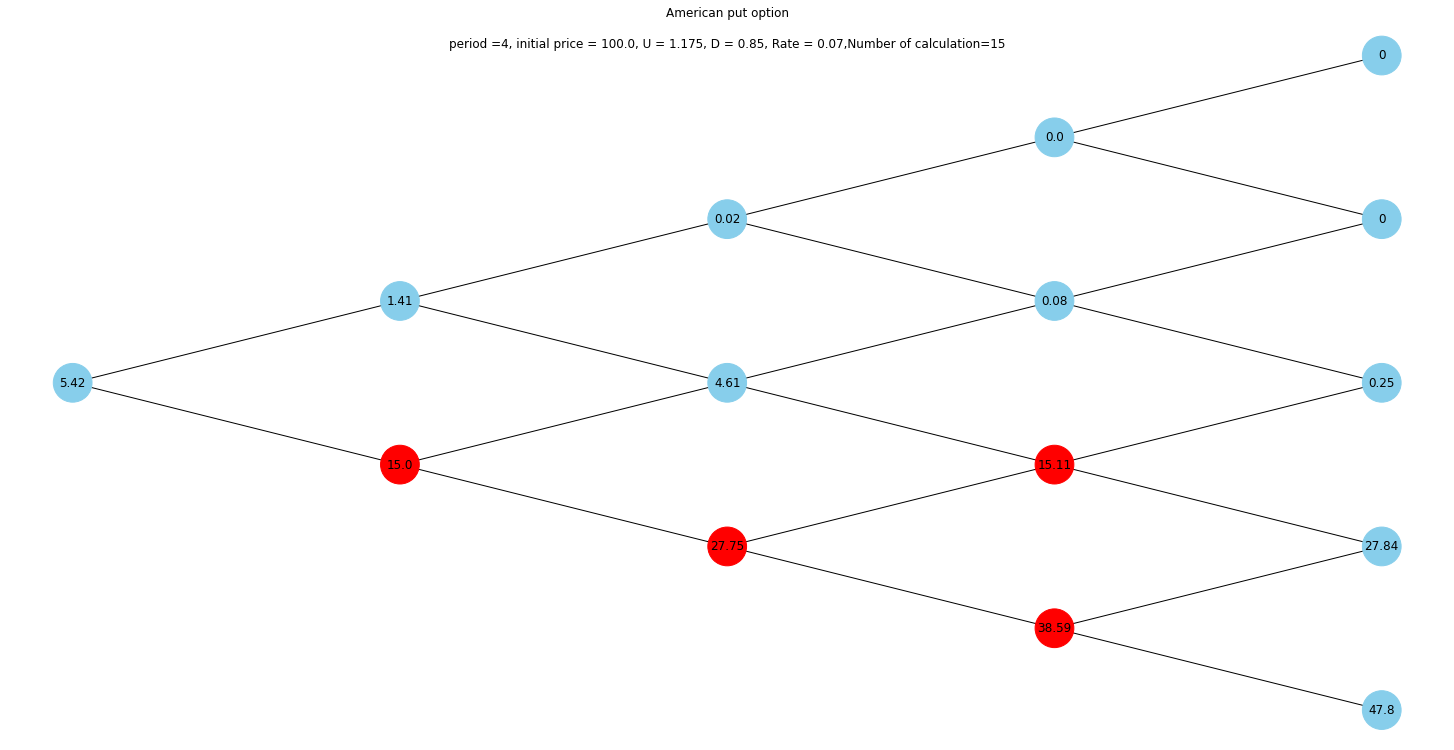

In [18]:
##customize node size and fontsize here
size_of_nodes = 1500
size_of_font = 12

plt.figure(figsize=(20,10))
vals = construct_labels(initial_price,N,u,d)
labels = construct_nodelabel(vals,N)
nodepos = construct_nodepos(vals)
G = construct_node(vals,N)
nx.set_node_attributes(G, labels, 'label')
nx.draw(G,pos=nodepos,node_color='skyblue',node_size=size_of_nodes,node_shape='o',alpha=1,font_weight="bold",font_color='darkblue',fontsize=size_of_font)
plt.title('Stock price simulation')
plt.suptitle('period ={}, initial price = {}, U = {}, D = {}, Rate = {},Number of calculation={}'.format(N,initial_price,u,d,r,number_of_calculation))
nx.draw_networkx_labels(G, nodepos, labels)
plt.show()

if A_E =='European':

  plt.figure(figsize=(20,10))
  call_vals = construct_Ecallput_node(vals,K,N,u,d,r,'call')
  labels = construct_nodelabel(call_vals,N)
  nodepos = construct_nodepos(call_vals)
  G = construct_node(call_vals,N)
  nx.set_node_attributes(G, labels, 'label')
  nx.draw(G,pos=nodepos,node_color='skyblue',node_size=size_of_nodes,node_shape='o',alpha=1,font_weight="bold",font_color='darkblue',fontsize=size_of_font)
  plt.title('European call option')
  plt.suptitle('period ={}, initial price = {}, U = {}, D = {}, Rate = {},Number of calculation={}'.format(N,initial_price,u,d,r,number_of_calculation))
  nx.draw_networkx_labels(G, nodepos, labels)
  plt.show()

  plt.figure(figsize=(20,10))
  put_vals = construct_Ecallput_node(vals,K,N,u,d,r,'put')
  labels = construct_nodelabel(put_vals,N)
  nodepos = construct_nodepos(put_vals)
  G = construct_node(put_vals,N)
  nx.set_node_attributes(G, labels, 'label')
  nx.draw(G,pos=nodepos,node_color='skyblue',node_size=size_of_nodes,node_shape='o',alpha=1,font_weight="bold",font_color='darkblue',fontsize=size_of_font)
  plt.title('European put option')
  plt.suptitle('period ={}, initial price = {}, U = {}, D = {}, Rate = {},Number of calculation={}'.format(N,initial_price,u,d,r,number_of_calculation))
  nx.draw_networkx_labels(G, nodepos, labels)
  plt.show()

else:

  plt.figure(figsize=(20,10))
  call_vals_A= construct_Acallput_node(vals,K,N,u,d,r,'call')
  labels = construct_nodelabel(call_vals_A,N)
  nodepos = construct_nodepos(call_vals_A)
  G = construct_node(call_vals_A,N)
  nx.set_node_attributes(G, labels, 'label')
  nx.draw(G,pos=nodepos,node_color='skyblue',node_size=size_of_nodes,node_shape='o',alpha=1,font_weight="bold",font_color='darkblue',fontsize=size_of_font)
  plt.title('American call option')
  plt.suptitle('period ={}, initial price = {}, U = {}, D = {}, Rate = {},Number of calculation={}'.format(N,initial_price,u,d,r,number_of_calculation))
  nx.draw_networkx_labels(G, nodepos, labels)
  plt.show()

  plt.figure(figsize=(20,10))
  put_vals = construct_Ecallput_node(vals,K,N,u,d,r,'put')
  put_vals_A = construct_Acallput_node(vals,K,N,u,d,r,'put')
  Color_map = color_map(vals,put_vals,N,K)#should use put_vals instead of put_vals_A
  labels = construct_nodelabel(put_vals_A,N)
  nodepos = construct_nodepos(put_vals_A)
  G = construct_node(put_vals_A,N)
  nx.set_node_attributes(G, labels, 'label')
  nx.draw(G,pos=nodepos,node_color=Color_map,node_size=size_of_nodes,node_shape='o',alpha=1,font_weight="bold",font_color='darkblue',fontsize=size_of_font)
  plt.title('American put option')
  plt.suptitle('period ={}, initial price = {}, U = {}, D = {}, Rate = {},Number of calculation={}'.format(N,initial_price,u,d,r,number_of_calculation))
  nx.draw_networkx_labels(G, nodepos, labels)
  plt.show()